In [41]:
import gzip
import json
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
def open_file_df(path):
    rows = []
    with gzip.open(path, 'rt', encoding='utf-8') as f:
        for line in f:
            rows.append(json.loads(line))

    df = pd.DataFrame(rows)
    return df

In [43]:
df_rent = open_file_df('data/renttherunway_final_data.json.gz')
df_mod = open_file_df('data/modcloth_final_data.json.gz')

start with renttherunway dataset cleaning

In [44]:
# deal w string cols
str_cols = ["fit", "bust size", "rented for", "review_text","body type", "review_summary", "category"]
df_rent[str_cols] = df_rent[str_cols].astype("string")

#deal w int cols
int_cols = ["user_id", "item_id", "rating", "size", "age"]
for col in int_cols:
    df_rent[col] = pd.to_numeric(df_rent[col], errors='coerce').astype("Int64")

#weight col
df_rent["weight"] = (df_rent["weight"].astype("string").str.extract(r"(\d+)", expand=False) .astype("float"))

#height col helper function
def parse_height(x):
    if not isinstance(x, str):
        return np.nan

    # extract feet and inches
    m = re.match(r"^\s*(\d+)'\s*(\d+)?", x)
    if not m:
        return np.nan

    feet = float(m.group(1))
    inches = float(m.group(2)) if m.group(2) else 0.0

    return feet * 12 + inches

#apply height cleaning function
df_rent["height_inches"] = df_rent["height"].apply(parse_height)

#convert bust size to number(band) and letter(cup)

#band col
df_rent["bust_band"] = (df_rent["bust size"].str.extract(r"(\d+)", expand=False).astype("float"))

#cup col
df_rent["bust_cup"] = (df_rent["bust size"].str.extract(r"([a-zA-Z]+)", expand=False).str.upper())

#date col - use pd datetime
df_rent["review_date"] = pd.to_datetime(df_rent["review_date"], errors="coerce")


In [45]:
fit_dict={'fit':0, 'small':-1, 'large':1}
df_rent.fit = df_rent.fit.apply(lambda x: fit_dict[x])

In [46]:
df_rent['rented_for'] = df_rent['rented for'].replace('party: cocktail', 'party')

In [47]:
df_rent[df_rent.age>100].shape[0]/df_rent.shape[0]

0.00033758517533654644

In [48]:
# drop rows with age > 100?
df_rent = df_rent[df_rent.age <= 100]

# drop rows with age == 0?
df_rent = df_rent[df_rent.age != 0]

In [49]:
#reducing categories from 68 to 10

#10 categories definition
category_groups = {
    "dress": [
        "dress", "gown", "ballgown", "sheath", "shirtdress",
        "shift", "frock", "maxi", "mini", "midi"
    ],
    "jumpsuit/romper": [
        "jumpsuit", "romper", "overalls", "combo"
    ],
    "top": [
        "top", "blouse", "shirt", "tank", "tee", "t-shirt",
        "cami", "henley", "buttondown", "turtleneck", "blouson"
    ],
    "knitwear": [
        "sweater", "pullover", "knit", "cardigan", "crewneck",
        "hoodie", "sweatshirt", "sweatershirt"
    ],
    "pants": [
        "pants", "pant", "trouser", "trousers", "leggings",
        "legging", "jogger", "jeans", "culottes", "culotte",
        "sweatpants", "tight"
    ],
    "skirt": [
        "skirt", "skirts", "skort"
    ],
    "outerwear": [
        "jacket", "coat", "peacoat", "trench", "bomber",
        "blazer", "vest", "duster", "cape", "parka",
        "overcoat", "down"
    ],
    "ethnic/flowy": [
        "kaftan", "caftan", "kimono", "tunic", "poncho"
    ],
    "suit": ["suit"]
}

#make the map
category_map = {}
for new_cat, old_list in category_groups.items():
    for old_cat in old_list:
        category_map[old_cat] = new_cat

#apply mapping and set 'other' for unmapped
df_rent["category_clean"] = df_rent["category"].map(category_map).fillna("misc")


In [50]:
#review text

In [51]:
#do this during pre processing for the model

cup_order = ["AA", "A", "B", "C", "D", "DD", "DDD", "E", "F", "G"]
#df_rent["bust_cup"] = pd.Categorical(df_rent["bust_cup"],categories=cup_order,ordered=True)

In [64]:
df_rent['fit_label'] = df_rent['fit'].map({-1: "small", 0: "fit", 1: "large"})
df_rent

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,...,height,size,age,review_date,height_inches,bust_band,bust_cup,rented_for,category_clean,fit_label
0,0,420272,34d,2260466,137.0,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,...,"5' 8""",14,28,2016-04-20,68.0,34.0,D,vacation,jumpsuit/romper,fit
1,0,273551,34b,153475,132.0,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,...,"5' 6""",12,36,2013-06-18,66.0,34.0,B,other,dress,fit
3,0,909926,34c,126335,135.0,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,...,"5' 5""",8,34,2014-02-12,65.0,34.0,C,formal affair,dress,fit
4,0,151944,34b,616682,145.0,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,...,"5' 9""",12,27,2016-09-26,69.0,34.0,B,wedding,dress,fit
5,0,734848,32b,364092,138.0,8,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,...,"5' 8""",8,45,2016-04-30,68.0,32.0,B,date,dress,fit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192539,0,66386,34dd,2252812,140.0,10,work,Fit like a glove!,hourglass,LOVE IT!!! First Item Im thinking of buying!,...,"5' 9""",8,42,2016-05-18,69.0,34.0,DD,work,jumpsuit/romper,fit
192540,0,118398,32c,682043,100.0,10,work,The pattern contrast on this dress is really s...,petite,LOVE it!,...,"5' 1""",4,29,2016-09-30,61.0,32.0,C,work,dress,fit
192541,0,47002,36a,683251,135.0,6,everyday,"Like the other DVF wraps, the fit on this is f...",straight & narrow,"Loud patterning, flattering fit",...,"5' 8""",8,31,2016-03-04,68.0,36.0,A,everyday,dress,fit
192542,0,961120,36c,126335,165.0,10,wedding,This dress was PERFECTION. it looked incredib...,pear,loved this dress it was comfortable and photog...,...,"5' 6""",16,31,2015-11-25,66.0,36.0,C,wedding,dress,fit


now cleaning modcloth dataset

EDA for rent dataset

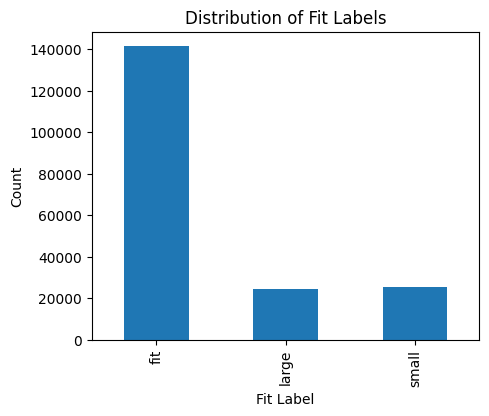

In [65]:
#distribution of fit labels
plt.figure(figsize=(5,4))
df_rent['fit_label'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of Fit Labels")
plt.xlabel("Fit Label")
plt.ylabel("Count")
plt.show()

The bar chart above shows a class imbalance with the majority of items fitting correctly, while "small" and "large" fit issues each represent only a small number of cases, which will require careful handling during model training to avoid biased predictions toward the majority "fit" class.

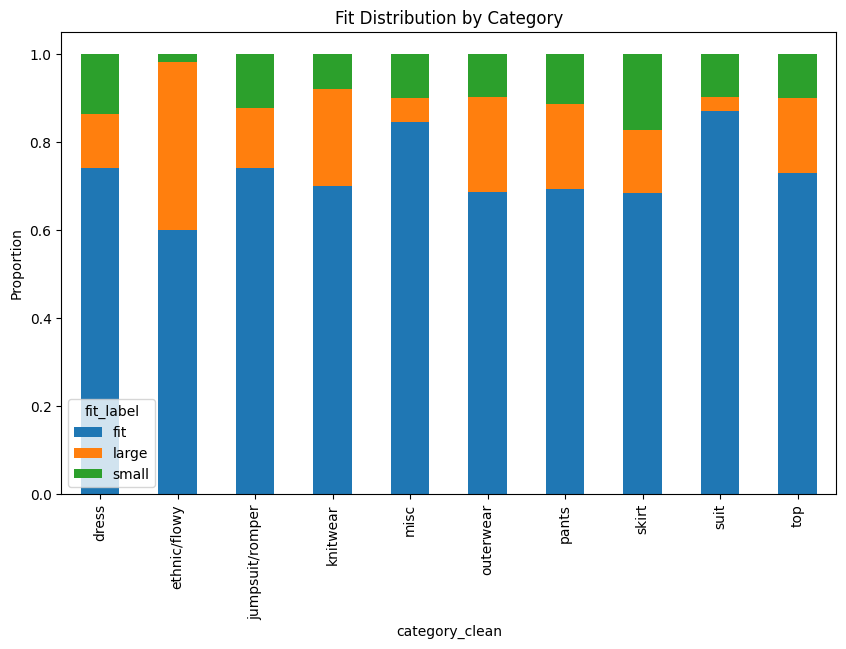

In [67]:
#fit disttibution by category
fit_by_cat = df_rent.groupby("category_clean")['fit_label'].value_counts(normalize=True).unstack()
fit_by_cat.plot(kind="bar", stacked=True, figsize=(10,6))
plt.title("Fit Distribution by Category")
plt.ylabel("Proportion")
plt.show()

Fit proportions vary moderately across clothing categories, with ethnic/flowy items showing the highest rate of large fit issues while suits have the highest fit rate, suggesting that category-specific features will be important predictors in the model.

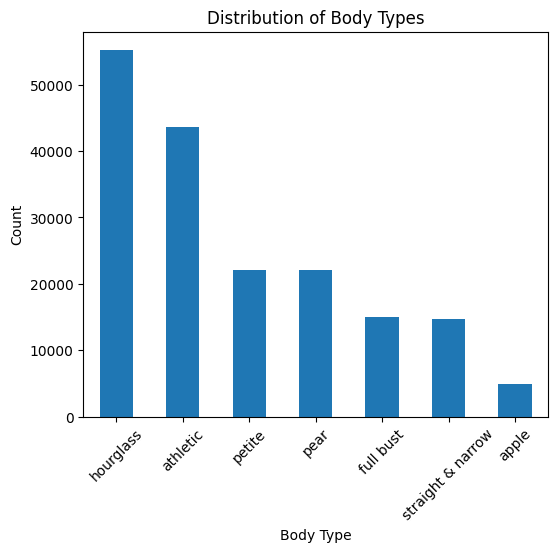

In [55]:
#body type distribution
plt.figure(figsize=(6,5))
df_rent["body type"].value_counts().plot(kind="bar")
plt.title("Distribution of Body Types")
plt.xlabel("Body Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

The chart above shows that the data is dominated by hourglass (~56,000) and athletic (~43,000) body types, with petite, pear, full bust, and straight & narrow body types moderately represented, and apple body type is significantly underrepresented (~5,000). This creates an imbalanced distribution that may affect model performance for less common body types.

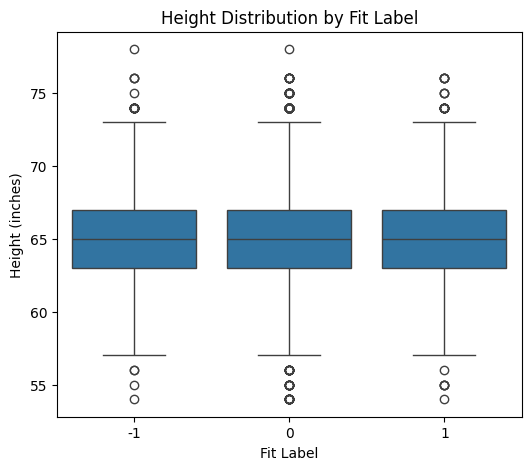

In [56]:
#height vs fit
plt.figure(figsize=(6,5))
sns.boxplot(data=df_rent, x="fit", y="height_inches")
plt.title("Height Distribution by Fit Label")
plt.xlabel("Fit Label")
plt.ylabel("Height (inches)")
plt.show()

Height shows nearly no relationship with fit label, as all three categories (small=-1, fit=0, large=1) have nearly identical distributions with medians around 65 inches and similar spreads, suggesting height alone is not a strong predictor of clothing fit.

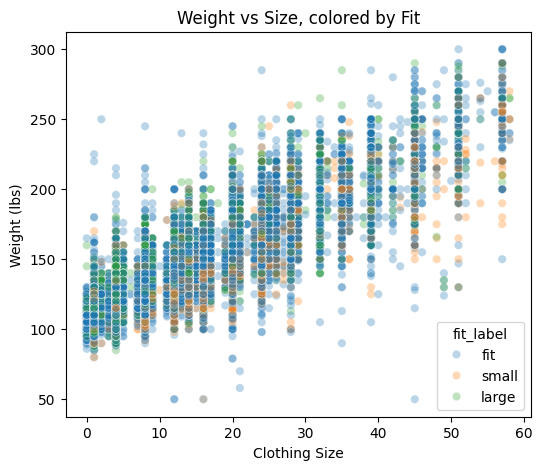

In [68]:
#weight vs size
plt.figure(figsize=(6,5))
sns.scatterplot(data=df_rent, x="size", y="weight", hue="fit_label", alpha=0.3)
plt.title("Weight vs Size, colored by Fit")
plt.xlabel("Clothing Size")
plt.ylabel("Weight (lbs)")
plt.show()

The scatter plot above shows overlap of all three fit categories across the weight-size spectrum, with no clear separation between "fit" (blue), "small" (orange), and "large" (green) labels. This suggests that predicting fit requires additional features beyond just weight and size, such as body type, garment category, or body proportions.

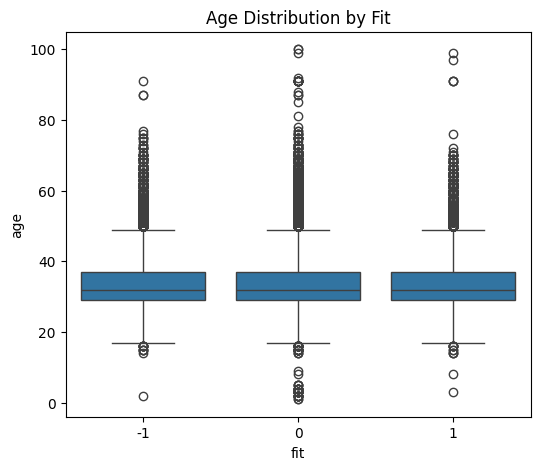

In [58]:
#fit trends by age
plt.figure(figsize=(6,5))
sns.boxplot(data=df_rent, x="fit", y="age")
plt.title("Age Distribution by Fit")
plt.show()

The age distributions look very similar across all three fit categories, suggesting that age does not meaningfully influence whether an item runs small, true to size, or large.

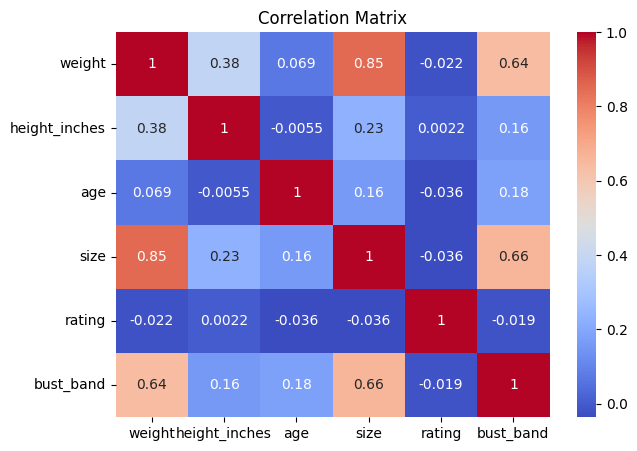

In [59]:
#correlations of numeric features
numeric_cols = ["weight", "height_inches", "age", "size", "rating", "bust_band"]
corr = df_rent[numeric_cols].corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

This correlation matrix above shows that weight has strong positive correlations with size (0.85) and bust_band (0.64). Most other variable pairs show weak correlations and the rating variable appears to be independent of physical measurements.

<Figure size 800x500 with 0 Axes>

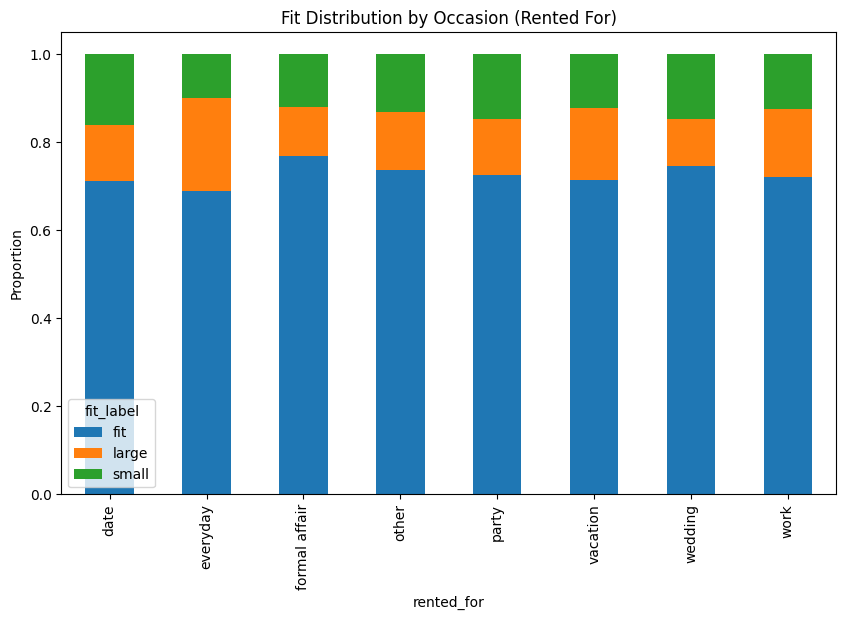

In [69]:
#fit vs reason for renting
plt.figure(figsize=(8,5))
df_rent.groupby("rented_for")["fit_label"].value_counts(normalize=True).unstack().plot(
    kind="bar", stacked=True, figsize=(10,6)
)
plt.title("Fit Distribution by Occasion (Rented For)")
plt.ylabel("Proportion")
plt.show()


This stacked bar chart shows that across all rental occasions, the majority of items fit correctly with large being more common than small among the misfits. Fit proportions remain relatively consistent regardless of the event type.

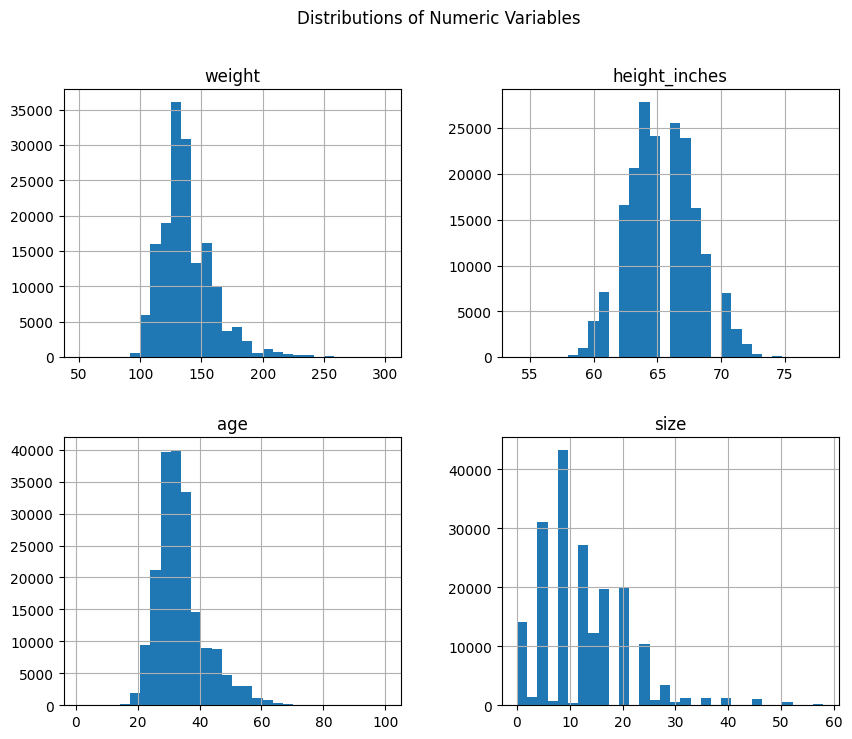

In [61]:
#distribution of numeric features
df_rent[["weight","height_inches","age","size"]].hist(bins=30, figsize=(10,8))
plt.suptitle("Distributions of Numeric Variables")
plt.show()

This figure shows the distributions of four numeric variables: weight is approximately normally distributed around 135 lbs, height clusters around 65-66 inches, age is right-skewed with most renters in their 30s, and size shows a  distribution with a peak smaller sizes around 8-10.